<a href="https://colab.research.google.com/github/mariaeco/imersao-dados-desafio-final/blob/main/ProjetoFinal_MariaMarcolina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROJETO IMERSÃO ALURA**
##*Título: Efeito do composto '87d714366' (um inibidor NFKB) sobre a expressão gênica*


### Aqui você irá encontrar
A) Uma seleção prévia de varáveis e compostos a serem  utilizados:
  Selecionamos alguns compostos com efeito inibidor mais frequente para modelarmos

B) Aprendizado de maquina para reconhecimento do composto inibidor escolhido


OBS: Toda a análise foi realizada em cima do composto mais replicado, mas como seria com o composto que gera mais expressão e tem pelo menos uma quantidade relativa de replicação? Entranto, acho que não seria viável, pois os compostos que levam a forte expressão gênica só tem 1 réplica (Explicado mais abaixo com base na avaliação do banco de dados) e não tem como inferir nem modelar bem algo que não tempos replicações suficientes.
---


Perguntas Iniciais:

1) Quais compostos tiveram algum efeito na ativação dos genes? Se o composto não teve efeito, não continuar a análise com ele. (Não significa que não ter efeito não é importante, se um composto for ruim, então é bom que ele não tenha efeito)
Exemplo: compostos classificados como nfkb_inhibitor mas que não causaram nenhum efeito sobre a expressão ou viabilidade, não atrapalhariam o Machine Learning?

2) Se apresentaram efeito, quais apresentaram efeito positivo sobre a ativação do gene e quais apresentaram efeito negativo?

3) Qual o mecanismo de ação (banco de dados 2) principal para o efeito sobre o gene?

Importante A quantidade de genes e compostos é enorme. Como trabalhar com isso? Selecionar o que vamos trabalhar? Então saber se o composto não teve efeito já é uma eliminação de variáveis. Mas às vezes um composto tem efeito sobre um gene ou grupo de genes e sobre outros não. Como tratar isso?
Mas, pelo que aprendi trabalhando com os dados, isso não é um problema. Serve para o computador  identificar no final qual composto será.

*Pacotes utilizados:*

In [1]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Juntando as Planilha dos Experimentos e Resultados
O que é o banco experimento e o que é o resposta?
* Os "g" são as expressões gênicas - que são respostas
* Os "c" são as células que receberam os tratamentos - o valor é a viabilidade

In [2]:
#@title
dados_exp = pd.read_csv('https://github.com/mariaeco/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true', compression = 'zip')
dados_exp.columns = dados_exp.columns.str.replace('-', '')
dados_exp.rename(columns={'droga': 'composto'}, inplace=True)
dados_exp

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...

In [3]:
#@title
dados_resultados = pd.read_csv('https://github.com/mariaeco/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true')
dados_resultados
dados_resultados['n_moa'] = dados_resultados.drop('id', axis=1).sum(axis=1)
dados_resultados['ativo_moa'] = ( dados_resultados['n_moa'] != 0)


### Merge

In [4]:
#@title
dados = pd.merge(dados_exp, dados_resultados, on='id')
#renomeando pra ficar mais bonito
dados.sort_values(['tratamento', 'composto', 'dose'], inplace=True)
dados['composto'] = dados['composto'].replace({'cacb2b860': 'Controle'})
dados['tratamento'] = dados['tratamento'].replace({'com_controle': 'Controle','com_droga': 'Tratamento' })
dados

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,n_moa,ativo_moa
25,id_0054388ec,Controle,48,D1,Controle,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
38,id_0079af0fb,Controle,24,D1,Controle,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
81,id_00d575cfb,Controle,72,D1,Controle,-0.6723,-0.1206,0.3467,-0.6395,-0.3117,1.2260,0.5376,0.4072,0.1072,0.2999,-0.5951,0.3314,-0.6563,-0.5825,-0.3253,-0.2861,1.8600,-0.2175,0.0644,-0.8179,0.5433,1.2210,-0.3418,0.0000,1.5970,0.3848,0.9079,-0.8118,-0.0735,-0.7087,0.3599,-0.2125,0.2554,0.1326,-1.0840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
148,id_01b05de6c,Controle,48,D1,Controle,-0.3176,0.8375,-0.3773,0.5555,-0.4877,0.3413,-0.8204,-1.1320,1.0220,2.8340,1.5950,-0.4357,2.4850,0.0169,0.3497,0.2446,0.9030,1.0480,-0.0236,0.1287,-0.2542,-0.9599,-1.2090,0.8248,1.2270,0.9403,1.2220,0.7952,0.0654,0.1419,0.4826,-0.3608,-1.2470,0.8987,-1.6590,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
175,id_01f1c58a2,Controle,72,D1,Controle,1.1220,0.7841,-0.4374,-0.0314,-0.4130,0.5947,0.8534,0.0790,0.3800,-0.2035,0.2127,-0.4461,1.0430,0.2279,0.0566,0.0000,-0.3716,0.1550,0.3925,-0.0826,0.1344,1.5450,-0.3988,0.7190,0.6027,-0.7236,0.9727,-0.7076,0.7918,-0.4296,-0.6394,0.1831,0.5052,0.0070,-0.6597,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22773,id_f48c19472,Tratamento,72,D1,fff7d208d,0.5408,-1.4560,-0.1473,0.4003,0.2285,0.3690,1.1740,-0.5140,-1.0500,-0.4816,0.4252,-0.7625,1.5500,1.2170,0.3908,-1.3730,0.5137,0.4466,1.1670,0.2632,0.1771,-0.3740,0.8383,-2.0820,-0.3954,1.4400,0.4031,0.3557,0.9868,0.7782,0.4559,-0.1629,0.2494,-0.1824,0.5438,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
23637,id_fdf860f5f,Tratamento,24,D1,fff7d208d,0.3602,0.1099,-0.2263,0.3325,0.6581,-0.6463,0.1821,-0.4568,-0.3015,0.0829,-0.3963,-0.1849,1.0660,0.8443,0.7604,-0.5483,0.0097,0.5490,0.3318,0.0000,-1.1260,-1.3260,0.6020,-1.0270,-0.7888,0.8839,-0.0975,-0.4090,0.2714,0.51

In [5]:
#@title
dados.ativo_moa.unique()

array([False,  True])

## Escolhendo qual subconjunto de dados trabalhar
* Escolhendo os compostos que vamos trabalhar com base no principio ativo, o principio ativo que tenha mais compostos

In [6]:
#@title
dados.drop(['id', 'tempo'], axis=1).select_dtypes('int64').sum(axis=0).sort_values(ascending=False).head(20)

n_moa                                16844
nfkb_inhibitor                         832
proteasome_inhibitor                   726
cyclooxygenase_inhibitor               435
dopamine_receptor_antagonist           424
serotonin_receptor_antagonist          404
dna_inhibitor                          402
glutamate_receptor_antagonist          367
adrenergic_receptor_antagonist         360
cdk_inhibitor                          340
egfr_inhibitor                         336
tubulin_inhibitor                      316
acetylcholine_receptor_antagonist      301
pdgfr_inhibitor                        297
hmgcr_inhibitor                        283
calcium_channel_blocker                281
flt3_inhibitor                         279
kit_inhibitor                          273
adrenergic_receptor_agonist            270
sodium_channel_inhibitor               267
dtype: int64

Com base no resultado acima ficou notável que o princípio ativo ```nfkb``` foi o que apresentou a maior quantidade de compostos
Vamos trabalhar com ele inicialmente

In [7]:
#@title
# selecionando alguns inibidores mais frequentes


sub_data = dados.query( 'tratamento == "Controle"| nfkb_inhibitor > 0 |dna_inhibitor > 0|kit_inhibitor  >0 |sodium_channel_inhibitor >0| \
                       hmgcr_inhibitor >0 | egfr_inhibitor   > 0 |flt3_inhibitor   > 0 ' )
sub_data = dados



 Reduzi para 20 compostos sendo 1 o controle

In [8]:
#@title
sub_data.tratamento.value_counts()

Tratamento    21948
Controle       1866
Name: tratamento, dtype: int64

In [9]:
#@title
sub_data.composto.value_counts(ascending=False)[:8]

Controle     1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
d08af5d4b     196
292ab2c28     194
d50f18348     186
Name: composto, dtype: int64

**Vemos acima que:**

---

1) O Controle tem bastante réplica

2) Temos o composto '87d714366' com 718 amostras, as quais são: 718/2 doses/ 3 tempos =~ 120 replicas

3) O composto '50e38451f' com 12 amostras, sendo: 12/2/3 = 2 réplicas

4) o restante dos compostos com 7/6 anmostras que terão apenas **1 réplica** (6/3/2), ou seja, são compostos que não podemos usá-los para a análise se não tiverem inseridos dentro de um grupo, pois uma réplica não representa nada.

*Vamos explorar um pouco mais abaixo, e avaliar se mantemos eles como ```nfkb_inhibitor``` ou não.*

In [10]:
#@title
sub_data.query('composto != "Controle"')['composto'].value_counts(normalize=True)*100 # observe a baixa quantidade dos demais compostos

87d714366    3.271369
9f80f3f77    1.120831
8b87a7a83    0.924913
5628cb3ee    0.920357
d08af5d4b    0.893020
               ...   
ed81f4046    0.004556
125db1da8    0.004556
a6334fda8    0.004556
f5487e91f    0.004556
cf21e6ee0    0.004556
Name: composto, Length: 3288, dtype: float64

Vamos observar o comportamento destes compostos em relação ao controle:

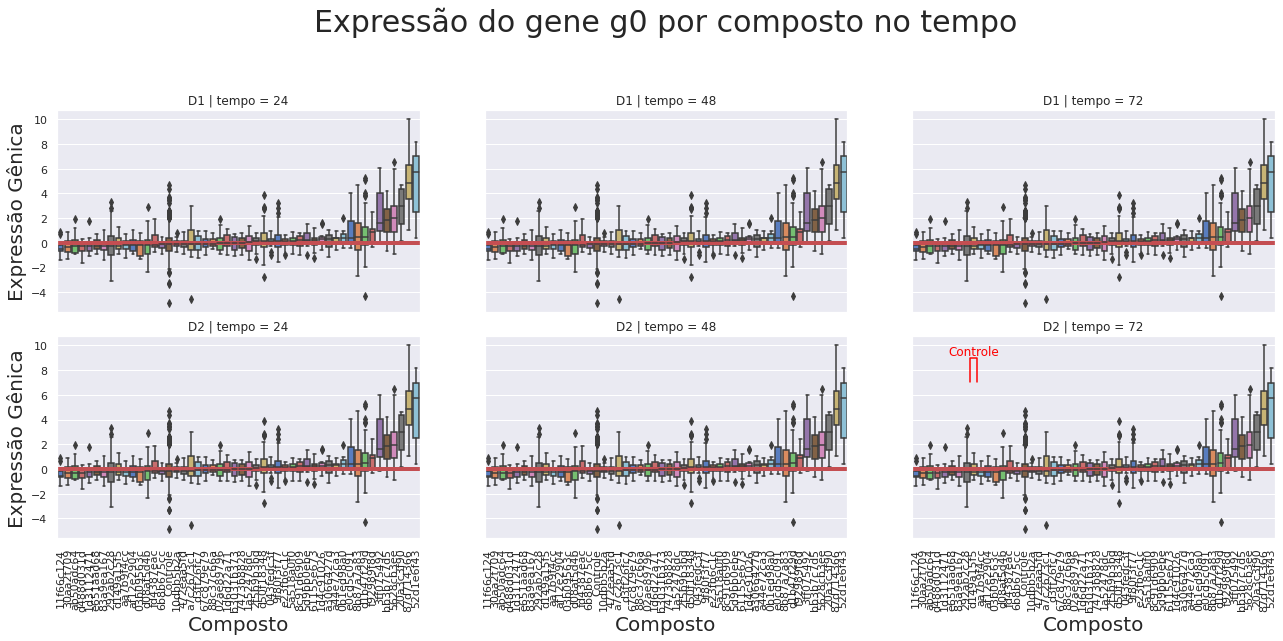

In [11]:
#@title
sns.set();
cod_compostos = sub_data.composto.value_counts().index[:50];
selected_compostos =sub_data.query('composto in @cod_compostos');

#para ordenar
grouped = selected_compostos.loc[:,['composto', 'g0']] \
    .groupby(['composto']) \
    .median() \
    .sort_values(by='g0')


g = sns.FacetGrid(selected_compostos,col='tempo',row='dose', despine=False, 
                  height=4, aspect=1.5);

g.map(sns.boxplot,x='composto',y='g0', palette='muted',order=grouped.index,
      data=selected_compostos);

g.map(plt.axhline, y=0, color = 'r', ls = '-', linewidth=4);
g.set_axis_labels("Composto", "Expressão Gênica", fontsize=20);
g.set_titles(row_template="{row_name}", fontsize=20);
g.set_xticklabels(rotation=90);
g.fig.subplots_adjust(top=0.80);
g.fig.suptitle('Expressão do gene g0 por composto no tempo', fontsize=30);

x1, x2= 7.5,8.5
y, h, col = selected_compostos['g0'].max()*0.7, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='red')
plt.text((x1+x2)*.5, y+h, "Controle", ha='center', va='bottom', color='red');

### Alguns comentários sobre a figura acima
### *Linha vermelha: expressão gênica igual a zero, um indicativo do composto não ter apresentado efeito sobre o gene*

1. Observamos que a maioria dos compostos *'aparentemente'* não diferem do controle. 

2. Temos os compostos (por ordem de surgimento nas figuras): '786d83020', 'f344437e0', 'b5e8fd5b5', '87d714366', '91dc8bab8' apresentaram aparentemente uma expressão gênica maior que o controle. Os demais tratamentos estão todos na linha do controle (Expressão genica = zero)

3. Isso foi independente da dose

4. Também não há uma grande mudança em relação ao tempo

*OBS: temos que ter em mente que isso é relacionado ao G0*

Vamos ver agora a ação dos compostos em outros genes

###**Vamos supor que a dose não influência e vamos tentar fazer um  mapa do efeito desses compostos sobre a expressão gênica dos diversos genes da tabela**
Cada vez que a figura abaixo é Gerada, vemos os efeitos dos 30 compostos mais abundantes sobre a expressão gênica.

In [12]:
#@title
# tenho que fazer um melt aqui para rodar para todos os genes
# selecionando aleatoriamente 6 colunas de genes para plotagem do gráfico
# a cada vez que executado gera captar 6 novos genes para avaliar

import random
lista =[]
for col in selected_compostos.columns:
    if (col[0] == 'g') and len(col)<5:
      lista.append(col)
lista = random.sample(lista, 10)


gens = selected_compostos[lista] #all gens go from 5:777
gens_data = pd.melt(selected_compostos, id_vars=['id','tratamento','tempo','dose',	'composto'], value_vars=gens )
gens_data.rename(columns={'value': 'Expression', 'variable':'Gene'}, inplace=True)
gens_data

,id,tratamento,tempo,dose,composto,Gene,Expression
0,id_0054388ec,Controle,48,D1,Controle,g28,0.1383
1,id_0079af0fb,Controle,24,D1,Controle,g28,0.1419
2,id_00d575cfb,Controle,72,D1,Controle,g28,-0.0735
3,id_01b05de6c,Controle,48,D1,Controle,g28,0.0654
4,id_01f1c58a2,Controle,72,D1,Controle,g28,0.7918
...,...,...,...,...,...,...,...
45425,id_6ec2280ab,Tratamento,24,D2,fd4387eac,g536,0.1585
45426,id_71f3dea0f,Tratamento,48,D2,fd4387eac,g536,-0.1292
45427,id_93bc52092,Tratamento,72,D2,fd4387eac,g536,0.0000
45428,id_bbd11a07d,Tratamento,48,D2,fd4387eac,g536,0.3277


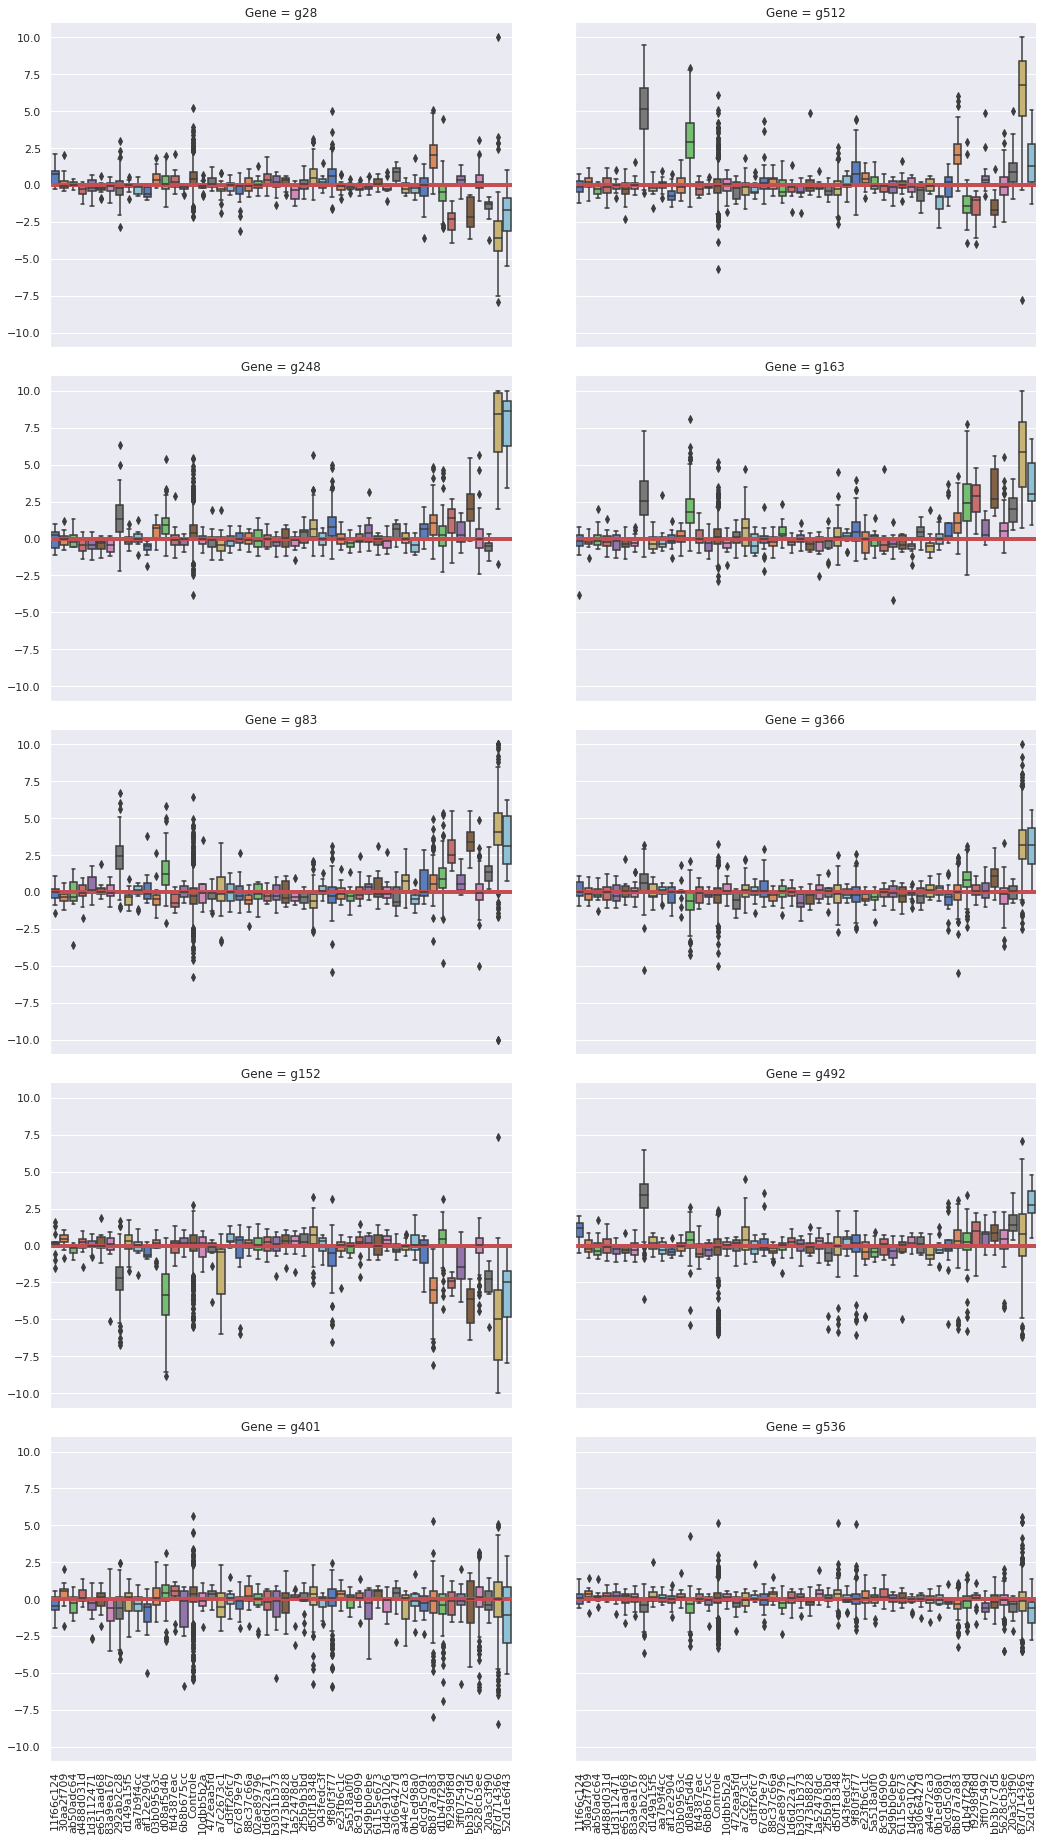

In [13]:
#@title
sns.set();
g = sns.catplot(x="composto", y="Expression", #hue = dose
                col="Gene",col_wrap=2, palette='muted',
                data=gens_data, kind="box",order=grouped.index,
                height=5, aspect=1.5);
g.map(plt.axhline, y=0, color = 'r', ls = '-', linewidth=4);
g.set_xticklabels(rotation=90);

Como podemos observar acima,plotando alguns genes, só os 4 último compostos tem algum tipo de efeito na expressão. Se rodarmos para os demais genes vai dar sempre esse padrão. Então, vamos eliminar todos os demais compostos.

In [14]:
#@title
#selected_compostos.to_csv('/content/selected_compostos.csv', index=False)

#**INVESTIGANDO SE O MODELO IDENTIFICA UM INIBIDOR NFKB ou UM COMPOSTO ESPECIFICO**

## Vimos que o inibifor nfbk '87d714366' é um dos que mais tem efeito sobre a expressão genica e tem bastante dado para uma modelagem

## Então vamos utilizar o composto '87d714366' como nosso y para detectar se nosso machine learn consegue detectar bem o composto '87d714366' de acordo com nosso bando de dados geral

In [26]:
#@title
## DEFINIR MEU COMPOSTO AQUI
### Se quero  um composto específico, rodar:
cod_compostos = dados.composto.value_counts().index[:];
selected_compostos = dados.query('composto in @cod_compostos');

var_new =[]
for compound in selected_compostos['composto']:
   if (compound == '87d714366'):     #'87d714366
       var_new.append(1)
   else:
       var_new.append(0)

selected_compostos['MeuComposto']= var_new;




# Resultado do modelo logístico:

In [16]:
#@title
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x = selected_compostos.select_dtypes('float64')
y = selected_compostos['MeuComposto']
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=1)

modelo_rlogistica = LogisticRegression(max_iter=1000)
modelo_rlogistica.fit(x_treino, y_treino)
modelo_rlogistica.score(x_teste, y_teste)

0.9995800965777871

# Resultado do Dummy:

In [17]:
#@title
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

modelo_dummy = DummyClassifier('most_frequent')
modelo_dummy.fit(x_treino, y_treino)
previsao_dummy = modelo_dummy.predict(x_teste)
accuracy_score(y_teste, previsao_dummy)

0.9697669536006719

# ÁRVORE DE DECISÃO

In [18]:
#@title
selected_compostos['MeuComposto'].value_counts(normalize=True)

0    0.96985
1    0.03015
Name: MeuComposto, dtype: float64

In [19]:
#@title
from sklearn.tree import DecisionTreeClassifier


x = selected_compostos.select_dtypes('float64')
y = selected_compostos['MeuComposto'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=1)

modelo_arvore = DecisionTreeClassifier(max_depth = 3)
modelo_arvore.fit(x_treino, y_treino)
modelo_arvore.score(x_teste, y_teste)

0.9972706277556163

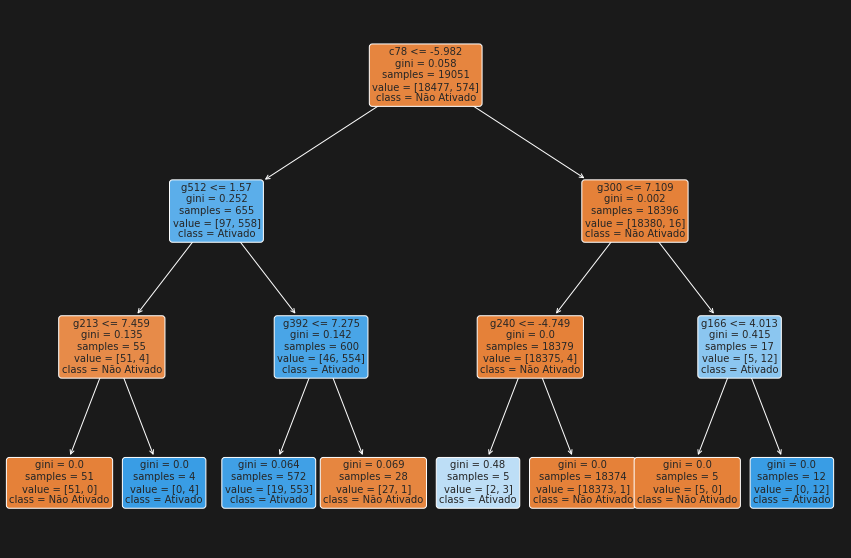

In [20]:
#@title
from sklearn import tree

fig, ax = plt.subplots(figsize=(15, 10), facecolor='k')
tree.plot_tree(modelo_arvore,
               ax=ax,
               fontsize=10,
               rounded=True,
               filled=True,
               feature_names=x_treino.columns,
               class_names=['Não Ativado', 'Ativado'])

plt.show() 


In [24]:
#@title
from sklearn.tree import DecisionTreeClassifier


x = selected_compostos.select_dtypes('float64')
y = selected_compostos['MeuComposto'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

teste=[]
treino=[]
for i in range(1,15):
    modelo_arvore = DecisionTreeClassifier(max_depth = i)
    modelo_arvore.fit(x_treino, y_treino)
    teste.append(modelo_arvore.score(x_teste, y_teste))
    treino.append(modelo_arvore.score(x_treino, y_treino)) 

# SIMULAÇÃO DO APRENDIZADO

[(0.99, 1.000356917908881)]

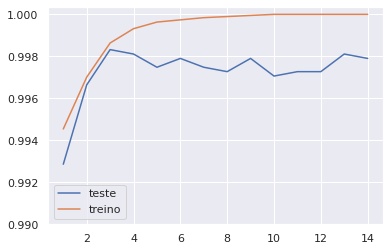

In [25]:
#@title
g=sns.lineplot(x=range(1,15), y = teste, label='teste');
sns.lineplot(x=range(1,15), y = treino, label='treino');
g.set(ylim=(0.99,None));

#APONTAMENTOS FINAIS

TESTE E TREINO DEVEM CONVERGIR, MAS NÃO SEI SE MINHA LÓGICA ESTÁ CORRETA.


Não tive tempo de aprimorar o notebook, deixá-lo bonito, nesse ponto pensei mais na lógica.
Não avaliei a viabilidade das células em relação ao composto escolhido
